In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from src.data_loading import load_data
from skrub import MinHashEncoder
from sklearn.decomposition import PCA
from src.utils import FeaturesExtractor, FixedSizeSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from tabpfn import TabPFNClassifier
import pandas as pd
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
import time
from sentence_transformers import SentenceTransformer

In [ ]:
def encode(X, encoder_name):
    if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
        X = np.array(X)
    encoder_type, encoder_params = encoder_name.split("__", 1)
    if encoder_type == "lm":
        encoder = SentenceTransformer(encoder_params)
        return encoder.encode(X)
    elif encoder_type == "skrub":
        if encoder_params.startswith("minhash"):
            n_components = int(encoder_params.split("_")[1])
            encoder = MinHashEncoder(n_components=n_components)
            # reshape to 2d array
            # if pandas dataframe, convert to numpy array
            X = X.reshape(-1, 1)
            return encoder.fit_transform(X)
        else:
            raise ValueError(f"Unknown skrub encoder {encoder_params}")

In [14]:
encodings = ["skrub__minhash_10", "skrub__minhash_30", "lm__all-MiniLM-L12-v2", "lm__whaleloops/phrase-bert"]
datasets = ["journal_jcr_cls", "movies", "michelin", "spotify", "employee_salary", "drug_directory", "museums", "fifa_footballplayers_22", "jp_anime"]
dim_reductions = {"PCA_10": PCA(n_components=10), "PCA_30": PCA(n_components=10), "subset_10": FeaturesExtractor(method="first", n_features=10), "subset_30": FeaturesExtractor(method="first", n_features=30),
                  "subset_biggest_10": FeaturesExtractor(method="biggest_variance", n_features=10), "subset_biggest_30": FeaturesExtractor(method="biggest_variance", n_features=30),
                  "passthrough": "passthrough"}
models = {"LogisticRegression": LogisticRegression(), "GradientBoostingClassifier": GradientBoostingClassifier(), "TabPFNClassifier": TabPFNClassifier(device="cpu")}
print("Number of iterations: ", len(datasets) * len(encodings) * len(dim_reductions) * len(models))

def run_on_encoded_data(X_enc, y, dim_reduction_name, dim_reduction, model_name, model):
    if dim_reduction_name == "passthrough" and model_name != "LogisticRegression" and not encoding.startswith("skrub"):
        return None
    if dim_reduction_name != "passthrough" and encoding.startswith("skrub"):
        return None
    pipeline = Pipeline([("dim_reduction", dim_reduction), ("model", model)])
    cv = FixedSizeSplit(n_splits=5, n_train=1000, n_test=4000)
    scores = cross_val_score(pipeline, X_enc, y, scoring="accuracy", cv=cv)
    return scores

results = pd.DataFrame(columns=["dataset", "encoding", "dim_reduction", "model", "accuracy"])

for dataset in tqdm(datasets):
    for encoding in tqdm(encodings, leave=False):
        #TODO do a proper sklearn transform (not a problem for sentence transformers)
        # right now not done for speed reasons and gpu handling
        print(f"Dataset: {dataset}, Encoding: {encoding}")
        X, y = load_data(dataset, max_rows=10000)
        X_enc = encode(X, encoding)

        # # run with joblib
        results_data_enc = Parallel(n_jobs=-1)(delayed(run_on_encoded_data)(X_enc, y, dim_reduction_name, dim_reduction,model_name, model) for (dim_reduction_name, dim_reduction) in dim_reductions.items() for (model_name, model) in models.items())
        start_time = time.time()
        for dim_reduction_name, dim_reduction in dim_reductions.items():
            for model_name, model in models.items():
                scores = results_data_enc.pop(0)
                if scores is None:
                    continue
                results = pd.concat([results, pd.DataFrame({"dataset": dataset, "encoding": encoding, "dim_reduction": dim_reduction_name, "model": model_name, "accuracy": scores})])
        print(f"Time elapsed: {time.time() - start_time}")



Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Number of iterations:  756


  0%|          | 0/9 [00:00<?, ?it/s]

Dataset: journal_jcr_cls, Encoding: skrub__minhash_10
Original task: classification for journal_jcr_cls
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Ex

Time elapsed: 0.0029447078704833984
Dataset: journal_jcr_cls, Encoding: skrub__minhash_30
Original task: classification for journal_jcr_cls
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Time elapsed: 0.0011892318725585938
Dataset: journal_jcr_cls, Encoding: lm__all-MiniLM-L12-v2
Original task: classification for journal_jcr_cls
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `token

Time elapsed: 0.008070945739746094
Dataset: journal_jcr_cls, Encoding: lm__whaleloops/phrase-bert
Original task: classification for journal_jcr_cls
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `t

/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Tr

 11%|█         | 1/9 [00:34<04:39, 34.96s/it]

Time elapsed: 0.007950305938720703


Dataset: movies, Encoding: skrub__minhash_10
Original task: regression for movies
Converting to binary classification
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if 

Time elapsed: 0.0012049674987792969
Dataset: movies, Encoding: skrub__minhash_30
Original task: regression for movies
Converting to binary classification
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid us

Time elapsed: 0.0011186599731445312
Dataset: movies, Encoding: lm__all-MiniLM-L12-v2
Original task: regression for movies
Converting to binary classification
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoi

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Time elapsed: 0.010854244232177734
Dataset: movies, Encoding: lm__whaleloops/phrase-bert
Original task: regression for movies
Converting to binary classification
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process 

/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Tr

 22%|██▏       | 2/9 [01:07<03:55, 33.61s/it]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Time elapsed: 0.008118867874145508


Dataset: michelin, Encoding: skrub__minhash_10
Original task: classification for michelin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set t

Time elapsed: 0.001201629638671875
Dataset: michelin, Encoding: skrub__minhash_30
Original task: classification for michelin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the f

Time elapsed: 0.0011665821075439453
Dataset: michelin, Encoding: lm__all-MiniLM-L12-v2
Original task: classification for michelin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before 

Time elapsed: 0.00830531120300293
Dataset: michelin, Encoding: lm__whaleloops/phrase-bert
Original task: classification for michelin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Tr

 33%|███▎      | 3/9 [01:40<03:18, 33.16s/it]

Time elapsed: 0.008167505264282227


Dataset: spotify, Encoding: skrub__minhash_10
Original task: classification for spotify
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the

Time elapsed: 0.0011970996856689453
Dataset: spotify, Encoding: skrub__minhash_30
Original task: classification for spotify
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fo

Time elapsed: 0.0012073516845703125
Dataset: spotify, Encoding: lm__all-MiniLM-L12-v2
Original task: classification for spotify
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before th

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Time elapsed: 0.011551141738891602
Dataset: spotify, Encoding: lm__whaleloops/phrase-bert
Original task: classification for spotify
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after paralle

/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


 44%|████▍     | 4/9 [02:14<02:48, 33.62s/it]

Time elapsed: 0.008079290390014648


Dataset: employee_salary, Encoding: skrub__minhash_10
Original task: regression for employee_salary
Converting to binary classification
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` b

Time elapsed: 0.0013606548309326172
Dataset: employee_salary, Encoding: skrub__minhash_30
Original task: regression for employee_salary
Converting to binary classification


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Time elapsed: 0.0010266304016113281
Dataset: employee_salary, Encoding: lm__all-MiniLM-L12-v2
Original task: regression for employee_salary
Converting to binary classification
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Time elapsed: 0.011063814163208008
Dataset: employee_salary, Encoding: lm__whaleloops/phrase-bert
Original task: regression for employee_salary
Converting to binary classification
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Time elapsed: 0.008634090423583984


Dataset: drug_directory, Encoding: skrub__minhash_10
Original task: classification for drug_directory


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Time elapsed: 0.0008366107940673828
Dataset: drug_directory, Encoding: skrub__minhash_30
Original task: classification for drug_directory
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers`

/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Time elapsed: 0.0012755393981933594
Dataset: drug_directory, Encoding: lm__all-MiniLM-L12-v2
Original task: classification for drug_directory
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can

Time elapsed: 0.008371114730834961
Dataset: drug_directory, Encoding: lm__whaleloops/phrase-bert
Original task: classification for drug_directory
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


 67%|██████▋   | 6/9 [03:40<02:03, 41.23s/it]

Time elapsed: 0.008210182189941406


Dataset: museums, Encoding: skrub__minhash_10
Original task: regression for museums
Converting to binary classification
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Time elapsed: 0.0014157295227050781
Dataset: museums, Encoding: skrub__minhash_30
Original task: regression for museums
Converting to binary classification
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Time elapsed: 0.0010960102081298828
Dataset: museums, Encoding: lm__all-MiniLM-L12-v2
Original task: regression for museums
Converting to binary classification
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M param

Time elapsed: 0.007586240768432617
Dataset: museums, Encoding: lm__whaleloops/phrase-bert
Original task: regression for museums
Converting to binary classification
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


 78%|███████▊  | 7/9 [04:13<01:17, 38.50s/it]

Time elapsed: 0.008290529251098633


Dataset: fifa_footballplayers_22, Encoding: skrub__minhash_10
Original task: regression for fifa_footballplayers_22
Converting to binary classification
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Time elapsed: 0.0011794567108154297
Dataset: fifa_footballplayers_22, Encoding: skrub__minhash_30
Original task: regression for fifa_footballplayers_22
Converting to binary classification


Time elapsed: 0.0011909008026123047
Dataset: fifa_footballplayers_22, Encoding: lm__all-MiniLM-L12-v2
Original task: regression for fifa_footballplayers_22
Converting to binary classification
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Time elapsed: 0.008221149444580078
Dataset: fifa_footballplayers_22, Encoding: lm__whaleloops/phrase-bert
Original task: regression for fifa_footballplayers_22
Converting to binary classification


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Time elapsed: 0.008066654205322266


Dataset: jp_anime, Encoding: skrub__minhash_10
Original task: regression for jp_anime
Converting to binary classification


Time elapsed: 0.0008862018585205078
Dataset: jp_anime, Encoding: skrub__minhash_30
Original task: regression for jp_anime
Converting to binary classification
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Time elapsed: 0.001291513442993164
Dataset: jp_anime, Encoding: lm__all-MiniLM-L12-v2
Original task: regression for jp_anime
Converting to binary classification
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Time elapsed: 0.00855255126953125
Dataset: jp_anime, Encoding: lm__whaleloops/phrase-bert
Original task: regression for jp_anime
Converting to binary classification
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


100%|██████████| 9/9 [05:14<00:00, 34.93s/it]

Time elapsed: 0.009312152862548828


In [15]:
# save results
#results.to_csv("results.csv", index=False)

In [29]:
results

,dataset,encoding,dim_reduction,model,accuracy
0,journal_jcr_cls,skrub__minhash_10,passthrough,LogisticRegression,0.53550
1,journal_jcr_cls,skrub__minhash_10,passthrough,LogisticRegression,0.54750
2,journal_jcr_cls,skrub__minhash_10,passthrough,LogisticRegression,0.54550
3,journal_jcr_cls,skrub__minhash_10,passthrough,LogisticRegression,0.54525
4,journal_jcr_cls,skrub__minhash_10,passthrough,LogisticRegression,0.53850
...,...,...,...,...,...
1795,jp_anime,lm__whaleloops/phrase-bert,passthrough,LogisticRegression,0.54050
1796,jp_anime,lm__whaleloops/phrase-bert,passthrough,LogisticRegression,0.55975
1797,jp_anime,lm__whaleloops/phrase-bert,passthrough,LogisticRegression,0.56300
1798,jp_anime,lm__whaleloops/phrase-bert,passthrough,LogisticRegression,0.56100


171


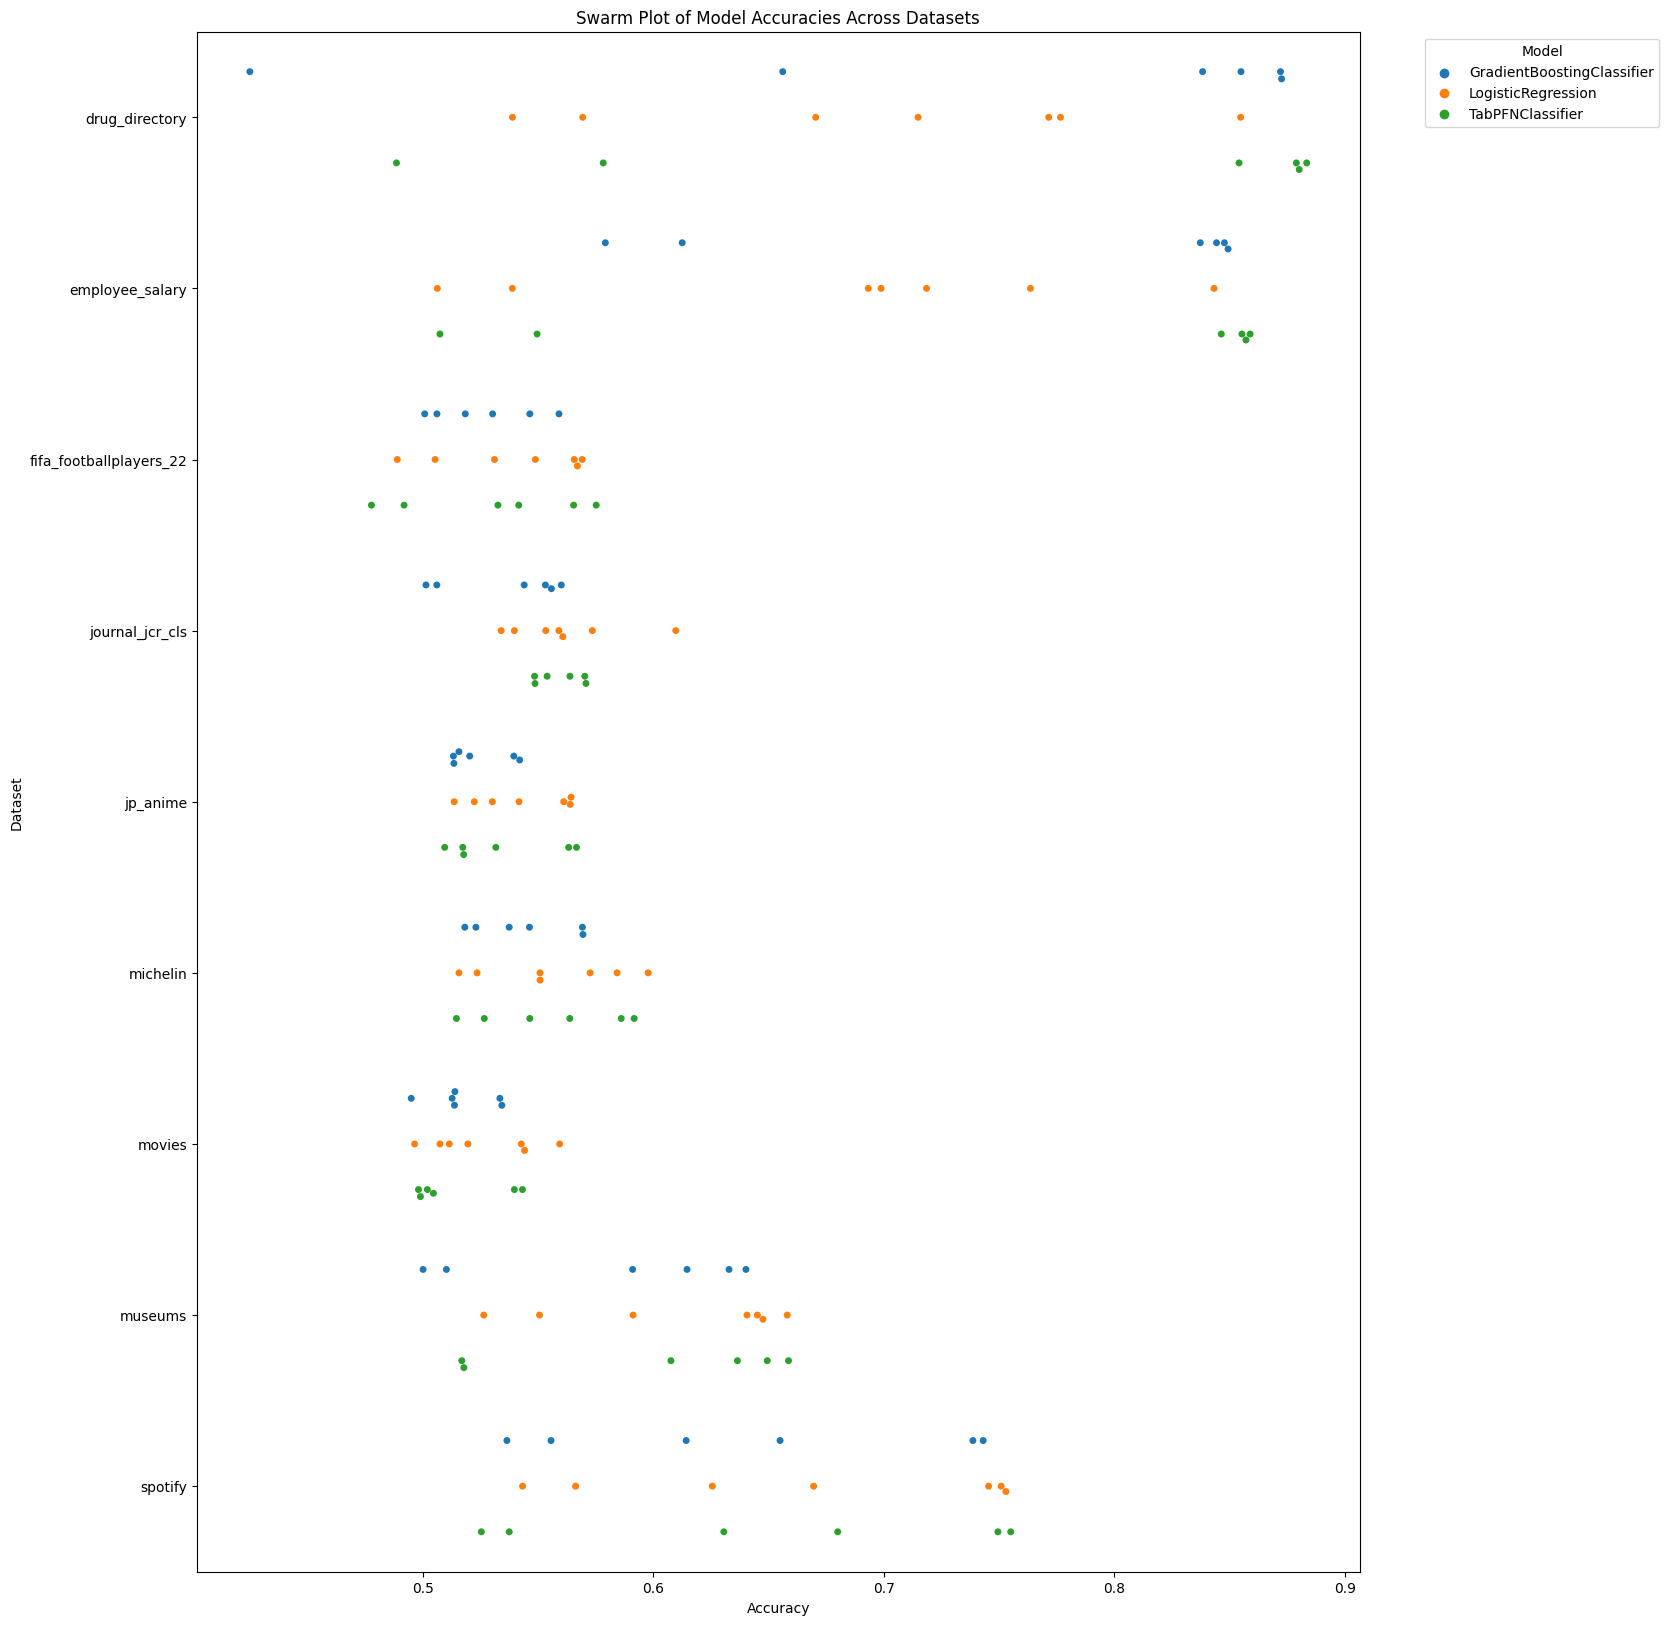

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
results = pd.read_csv("../results/results.csv")
#esults['mean_accuracy'] = results['accuracy'].apply(np.mean)
#melted_results = results
# "Melting" the data to make it suitable for a swarmplot
#melted_results = results.explode('accuracy')
#melted_results['accuracy'] = melted_results['accuracy'].astype(float)
# average the accuracy scores in the accuracy column

# filter for encoding =lm__all-MiniLM-L12-v2
# take the mean of accuracy
melted_results = results.groupby(['dataset', 'model', 'dim_reduction', 'encoding']).mean().reset_index()
#melted_results = results.explode('accuracy')
#melted_results['accuracy'] = melted_results['accuracy'].astype(float)
melted_results = melted_results[melted_results['encoding'] == 'lm__all-MiniLM-L12-v2']
print(len(melted_results))

# Creating the swarmplot
# plt.figure(figsize=(15, 20))
# sns.swarmplot(data=melted_results, x='accuracy', y='dataset', hue='model', dodge=True)
# plt.title('Swarm Plot of Model Accuracies Across Datasets')
# plt.xlabel('Accuracy')
# plt.ylabel('Dataset')
# plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()
# Create the plot
fig = px.strip(
    data_frame=melted_results,
    x="accuracy",
    y="dataset",
    color="model",
    title="Swarm Plot of Model Accuracies Across Datasets",
    labels={"accuracy": "Accuracy", "dataset": "Dataset"},
    height=600,
    width=900,
)

# Show the figure
fig.show()

In [4]:
# compare speed on cpu and gpu
X, y = load_data("spotify", max_rows=10000)
# label encoding
#y = y.astype('category').cat.codes
#y = y.astype(np.int64)
#X_enc = encode(X, "lm__all-MiniLM-L12-v2")

Original task: classification for spotify


In [13]:
# Choose a tokenizer and BERT model that work together
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler, ProgressBar
from skorch.hf import HuggingfacePretrainedTokenizer
# import LambdaLR from torch.optim.lr_scheduler
from torch.optim.lr_scheduler import LambdaLR
from src.models import BertAndTabPFN

TOKENIZER = "distilbert-base-uncased"
PRETRAINED_MODEL = "distilbert-base-uncased"

# model hyper-parameters
OPTMIZER = torch.optim.AdamW
LR = 5e-5
MAX_EPOCHS = 3
CRITERION = nn.CrossEntropyLoss
BATCH_SIZE = 8

# device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

num_training_steps = MAX_EPOCHS * (len(X) // BATCH_SIZE + 1)

def lr_schedule(current_step):
    factor = float(num_training_steps - current_step) / float(max(1, num_training_steps))
    assert factor > 0
    return factor

class BertModule(nn.Module):
    def __init__(self, name, num_labels):
        super().__init__()
        self.name = name
        self.num_labels = num_labels
        
        self.reset_weights()
        
    def reset_weights(self):
        self.bert = AutoModelForSequenceClassification.from_pretrained(
            self.name, num_labels=self.num_labels
        )
        
    def forward(self, **kwargs):
        pred = self.bert(**kwargs)
        return pred.logits
    
class BertAndTabPFNWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, X, **fit_params):
        y = fit_params.get("y", None)
        return self.model(X, y)
    
#wrapped_model = BertAndTabPFNWrapper(BertAndTabPFN)

class HuggingfacePretrainedTokenizerWithY(HuggingfacePretrainedTokenizer):
    def transform(self, X):
        res = super().transform(X)
        res["y"] = y
        return res

pipeline = Pipeline([
    ('tokenizer', HuggingfacePretrainedTokenizerWithY(TOKENIZER)),
    ('net', NeuralNetClassifier(
        BertAndTabPFN,
        module__dim_tabpfn=50, 
        module__preprocess_before_tabpfn=False,
        #module__name=PRETRAINED_MODEL,
        #module__num_labels=len(set(y)),
        optimizer=OPTMIZER,
        lr=LR,
        max_epochs=MAX_EPOCHS,
        criterion=CRITERION,
        batch_size=BATCH_SIZE,
        iterator_train__shuffle=True,
        device=DEVICE,
        callbacks=[
            LRScheduler(LambdaLR, lr_lambda=lr_schedule, step_every='batch'),
            ProgressBar(),
        ],
    )),
])

In [14]:
HuggingfacePretrainedTokenizerWithY(TOKENIZER).fit_transform(X[:10], y[:10])

TypeError: HuggingfacePretrainedTokenizerWithY.transform() missing 1 required positional argument: 'y'

In [8]:
pipeline.fit(X, y)


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


  0%|          | 0/1250 [00:00<?, ?it/s]

fit_params {}


NameError: name 'y' is not defined

In [20]:

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklea

class CustomTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # return self for compatibility reasons

    def transform(self, X, y=None):
        # Your code here that uses both X and y
        print("X", X.shape)
        print("y", y.shape)
        return X
    
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('custom_transformer', CustomTransformer())
])

SyntaxError: invalid syntax (1303619598.py, line 4)

In [ ]:
X, y = np.random.rand(100, 10), np.random.randint(0, 2, 100)

pipeline.fit(X, y)

TypeError: float() argument must be a string or a real number, not 'ellipsis'